# Simulating moving objects

## Contents
+ Simulating realistic motion using the formulas for *velocity* and *acceleration*
+ Introducing the velocity and acceleration vectors
+ Using Euler's method to approximate the position of a moving objects
+ Finding the exact trajectory of a moving object using calculus

## Introduction

To implement motion in a videogame, like our *Asteroid* bootleg, we need to use many of the calculus concepts from the previous chapter.

The numerical entities we will consider are the $ x $ and $ y $ positions of the asteroids and the spaceship. Those will be functions of the time, so we will have $ x(t) $ and $ y(t) $.

We will consider the following physical functions:
+ *velocity* &mdash; the derivative of the position function with respect to time.
+ *acceleration* &mdash; the derivative of velocity with respect to time.

As we have two functions $ x(t) $ and $ y(t) $ to determine the position of objects, we'll have two velocity functions and two acceleration functions, which will allow us to think in terms of vectors as well.

Our first goal will consist in get the asteroids moving. To do that, we'll provide them with random, constant velocity functions. Then, we'll *integrate* these functions in real time to get their positions. We will use *Euler's method* to do that, which is a mathematically similar method for integration, with the advantage that it can be done as the game runs.

The second goal will be to let the user move the spaceship. When the user presses any of the direction keys, the spaceship should *accelerate* on the direction of the pressed key, which means that the velocity will change, and as a result the position of the spaceship as well.

Our third and final goal will consist in deep diving on the *Euler's method* as a way to obtain an approximation of the integral, and compare it with the exact solutions.

## Simulating a constant velocity motion

In everyday usage, velocity is synonym with speed. In math and physics, velocity includes both the notions of speed and direction of motion &mdash; this means velocity is a vector!

In our game, we will enhance the asteroid objects with a random velocity vector $ (vx, vy) $, and consider those to be the constant values of the derivatives of the position functions with respect to time.

$
x'(t) = vx \\
y'(t) = vy
$

For simplicity, we will talk about:

$
s(t) = (x(t), y(t)) \\
v(t) = (x'(t), y'(t))
$

As if they were vector-valued functions, but it just means that those are individual functions that take time and return values that we will interpret as vectors.

### Adding velocities to the asteroids

Let's recap where we left our *Asteroids* bootleg. We created a hierarchy of classes that modeled our game entities first in a *math* world of coordinates and vectors and some functions that translated that model into the *game* world of pixels and frames.

In the last step of the game, we even made our spacechip to rotate as can be seen when running [Asteroids: step 3](../e00-my-lib/asteroids_step3.py). In that stage, all the asteroids were static.

In [4]:
from asteroids_step3 import main 

main()

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 0

This *math* model was supported by the `PolygonModel` class. As all of our game entities inherit from it, and all of them are subject of being moved, we will start by adding the velocity vector components as properties:

```python
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

        # vx, vy are the velocity components
        self.vx = 0
        self.vy = 0
```

Next, to make our asteroids to move erratically we can assign them with random velocity values:

```python
class Asteroid(PolygonModel):
    def __init__(self):
        sides = randint(5, 9)
        points = [to_cartesian((uniform(0.5, 1.0), 2 * pi * i / sides))
            for i in range(0, sides)
        ]
        super().__init__(points)

        # assign random velocity values
        self.vx = uniform(-1, 1)
        self.vy = uniform(-1, 1)
```

That will make `vx` and `vy` to take a random value between $ (-1, 1) $, with negative values for the velocity meaning the position of the corresponding coordinate will decrease, instead of increase.

### Updating the game engine to move the asteroids

With the velocity values given, we need to use them to update the the game entities position `x` and `y`.

If $ \Delta t $ is the elapsed time between frames, we know that x will change according to:

$ 
x = x + vx \times \Delta t \\
y = y + vy \times \Delta t
$

This is a good way to do it because velocities are constant, and we know that $ v = \frac{s}{t} $.

Thus, the way to make the asteroids move will be to update our `PolygonModel` to include a `move()` method that will update the game entity position:

```python
class PolygonModel():
...
    def move(self, milliseconds):
        dx, dy = (self.vx * milliseconds / 1000, self.vy * milliseconds / 1000)
        self.x, self.y = add((self.x, self.y), (dx, dy))
```

This has been the first application of algorithm known as the *Euler's method*.

The algorithm consists of keeping track of the value of one or more functions (in our case, $ x(t) $, $ y(t) $) and their derivatives ($ x'(t) $ and $ y'(t) $) and updating the functions according to their derivatives in each step.

This will be exact if the derivatives are constant, but it will even be a good approximation if they're not.

### Keeping the asteroids on the screen

As our game model space (that is the screen space) is fairly limited, any asteroid with a random velocity will be bound to drift off the screen at some point in time.

To keep the asteroids within the screen are, we can add some extra logic to keep the $ x $ and $ y $ coordinates between the min and max *math* values of $ (-10, 10) $.

One common solution in videogame scenarios (and the one that *Asteroids* used), consists in subtracting the width (or height) of the screen when one of the coordinate went over the limit.

This effect can be seen in the picture below:

![Teleportation](../images/teleportation.png)

This can be written in the `move()` method:

```python
class PolygonModel():
...
    def move(self, milliseconds):
        dx, dy = (self.vx * milliseconds / 1000, self.vy * milliseconds / 1000)
        self.x, self.y = add((self.x, self.y), (dx, dy))

        if self.x < -10:
            self.x += 20
        if self.y < -10:
            self.y += 20
        if self.x > 10:
            self.x -= 20
        if self.y > 10:
            self.y -= 20
```

With that we're done with the *math* model of our game, and we just need to adjust the *game* model so that we add the call to move the asteroid in every game loop iteration.

```python
def main():
...
    while not done:
        clock.tick()
...
        milliseconds = clock.get_time()
...
        for asteroid in asteroids:
            asteroid.move(milliseconds)

...
```

Those unremarkable 2 lines make all of our asteroids move according to the given velocity.

In [4]:
from asteroids_step4 import main

main()

SystemExit: 0

## Simulating acceleration

Let's assume that our spaceship is equipped with a thruster, that propels the spaceship in the direction it is pointed when it is burning fuel.

Let's also assume that the spaceship acceleration is constant when the rocket is firing its thruster. Because acceleration is defined as the derivative of velocity, constant acceleration means the velocity changes at a constant rate in both directions with respect to time.

That is, if $ ax $ and $ ay $ are the components of the constant acceleration:
$
vx'(t) = ax \\
vy'(t) = ay
$

Our goal is to give the Python spaceship a pair of properties representing $ ax $ and $ ay $. When the user is not pressing any buttons, the spaceship should have zero acceleration in both directions (and therefore, be stationary), while when user presses the corresponding key, the acceleration values should instantly be updated so that $ (ax, ay) $ is not zero.


### Accelerating the spaceship

By trial and error can be concluded that an acceleration magnitude of 3 makes the ship handling sufficiently accurate. 

This means that the spaceship will accelerate at $ 3 \frac{\frac{m}{s}}{s} $. That is, when the user presses the thrust key, the spaceship should increase its speed at a rate of $ 3 \frac{m}{s} $ every second.

As PyGame works in milliseconds, this means the relevant speed change will be $ 0.003 \frac{m}{s} $ per millisecond.

To calculate the acceleration vector we have to use trigonometry: we know that the magnitude of the acceleration will be $ | \vec{a} | = 3 $. Therefore, if the spaceship is rotated at a $ \theta $ angle, we know that $ ax = | \vec{a} | \cdot cos(\theta) $ and $ ay = | \vec{a} | \cdot sin(\theta) $.

![acceleration components](../images/acceleration_components.png)

In the game, during each iteration of the game loop, we will update the velocity of the ship before it moves:

Over an elapsed time $ \Delta t $, the change to vx will be $ ax \cdot \Delta t $ and the update to vy will be $ ay \cdot \Delta t $.

In [1]:
from asteroids_step5 import main

main()

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 0

## Digging deeper into Euler's method

> The core idea of Euler's method is given an initial value of a quantity (e.g. position), and an equation describing its derivatives (e.g. equation for the velocity and acceleration), the method tells us how to update the quantity.


Let's try to understand the details with an example:

Say an object starts at time $ t = 0 $, at position $ (0, 0) $ with an initial velocity $ (1, 0) $ and a constant acceleration $ (0, 0.2) $.

| NOTE: |
| :---- |
| The initial data tells us that the object is travelling from the origin to the right, but will veer upward over time. |

The goal is to find the values of the position vector every two seconds, from $ t = 0 $, to $ t = 10 $ using Euler's method. Once we get the data, and find a way to compute it manually and also programmatically, we'll draw position in the $x,\, y $ plane to show how the object moves.

### Carrying out Euler's method by hand

At any given time, the object can be characterized with the values for its position $ \vec{s} $, velocity $ \vec{v} $ and acceleration $ \vec{a} $. We can consider those to be vector-valued functions, and we will be using the following initial conditions:

| t     | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $|
| :---- | :------------- | :------------- | :------------ |
| $ 0 $ | $ (0, 0) $     | $ (1, 0) $     | $ (0, 0.2) $  |


Also, as stated before, we would like to get the position from time $ t = 0 $, to $ t = 10 $ in 2-second increments. Also, we know that the object's acceleration is constant.

Thus, the table we need to complete is:

| t      | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $|
| :----- | :------------- | :------------- | :------------ |
| $ 0 $  | $ (0, 0) $     | $ (1, 0) $     | $ (0, 0.2) $  |
| $ 2 $  |                |                | $ (0, 0.2) $  |
| $ 4 $  |                |                | $ (0, 0.2) $  |
| $ 6 $  |                |                | $ (0, 0.2) $  |
| $ 8 $  |                |                | $ (0, 0.2) $  |
| $ 10 $ |                |                | $ (0, 0.2) $  |

Now, let's use what we know to start filling out those empty cells.

We know that:

$
\displaystyle
a = \frac{v}{t} \Rightarrow v = a \cdot t
$

> That is, velocities change according to the given acceleration.

Now, we need to start computing the values for $ v_x $ and $ v_y $ in the given time intervals, starting with $ t = 2 $.

But, as $ a_x $ and $ a_y $ are known (and constant):

$
\displaystyle
v_x(2) = v_x(0) + a_x(0) \cdot \Delta t = 1 + 0 = 1 \\
v_y(2) = v_y(0) + a_y(0) \cdot \Delta t = 0 + 0.2 \cdot 2 = 0.4
$

And applying the same reasoning for calculating the position, we will have:

$
\displaystyle
v = \frac{s}{t}
$

> position change according to the given velocity

And as $ v_x $ and $ v_y $ for the initial conditions are known:

$
\displaystyle
x(2) = x(0) + v_x(0) \cdot \Delta t = 0 + 1 \cdot 2 = 2 \\
y(2) = y(0) + v_y(0) \cdot \Delta t = 0 + 0 \cdot 2 = 0 
$

Note that we're not using the recently calculated velocities for determining the position at $ t = 2 $, but instead, we use the values for the previous line, and assume that velocity was constant up to $ t = 2 $. That is, we assume that the velocity vector was $ v = (1, 0) $ for the time from $ t = 0 $ to $ t = 2 $. As the velocity was constant, the change in position can be calculated according to the formula: $ v = \frac{s}{t} $. Therefore, $ \Delta s = v \cdot \Delta t = 1 \cdot 2 = 2 $.

So now, we can fill the second row of the table:

| t      | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $|
| :----- | :------------- | :------------- | :------------ |
| $ 0 $  | $ (0, 0) $     | $ (1, 0) $     | $ (0, 0.2) $  |
| $ 2 $  | $ (2, 0) $     | $ (1, 0.4) $   | $ (0, 0.2) $  |
| $ 4 $  |                |                | $ (0, 0.2) $  |
| $ 6 $  |                |                | $ (0, 0.2) $  |
| $ 8 $  |                |                | $ (0, 0.2) $  |
| $ 10 $ |                |                | $ (0, 0.2) $  |

The good thing is that we've established the method to calculate the subsequent rows, so it is easier now:

$
\displaystyle 
v_x(4) = v_x(2) + a_x(2) \cdot \Delta t = 1 + 0 \cdot 2 = 1 \\
v_y(4) = v_y(2) + a_y(2) \cdot \Delta t = 0.4 + 0.2 \dot 2 = 0.8 \\
$

And for the position:

$
\displaystyle 
x(4) = x(2) + v_x(2) \cdot \Delta t = 2 + 1 \cdot 2 = 4 \\
y(4) = y(2) + v_y(2) \cdot \Delta t = 0 + 0.4 \dot 2 = 0.8 \\
$

Therefore:

| t      | $ \vec{s}(t) $ | $ \vec{v}(t) $ | $ \vec{a}(t) $|
| :----- | :------------- | :------------- | :------------ |
| $ 0 $  | $ (0, 0) $     | $ (1, 0) $     | $ (0, 0.2) $  |
| $ 2 $  | $ (2, 0) $     | $ (1, 0.4) $   | $ (0, 0.2) $  |
| $ 4 $  | $ (4, 0.8) $   | $ (1, 0.8) $   | $ (0, 0.2) $  |
| $ 6 $  |                |                | $ (0, 0.2) $  |
| $ 8 $  |                |                | $ (0, 0.2) $  |
| $ 10 $ |                |                | $ (0, 0.2) $  |

Although we could continue doing the calculations manually, we see that it is very simple (and less error-prone) to use Python to do so.

That will also give us the change to use smaller $ \Delta t $.

### Implementing the algorithm in Python

Implementing this algorithm in Python consists in automating what we've done manually:

In [3]:
from my_vectors import add, scale

# Initial parameters
t = 0
s = (0, 0)
v = (1, 0)
a = (0, 0.2)
dt = 2
steps = 5

positions = [s]
for _ in range(0, steps):
    t += 2
    s = add(s, scale(dt, v))
    v = add(v, scale(dt, a))
    positions.append(s)

# printing the table with positions
print('positions={}'.format(positions))


positions=[(0, 0), (2, 0), (4, 0.8), (6, 2.4000000000000004), (8, 4.800000000000001), (10, 8.0)]


We can also plot the object's trajectory according to Euler's method:

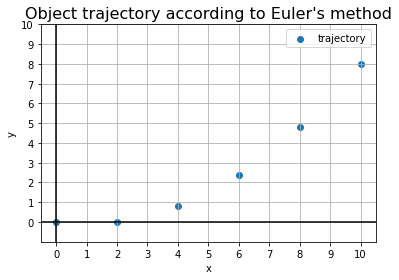

In [12]:
import matplotlib.pyplot as plt

positions=[(0, 0), (2, 0), (4, 0.8), (6, 2.4000000000000004), (8, 4.800000000000001), (10, 8.0)]

fig, ax = plt.subplots()
ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.title(
    'Object trajectory according to Euler\'s method', fontsize=16)

plt.ylim(-1, 10)
plt.xticks(range(0, 11))
plt.yticks(range(0, 11))

# plotting positions as a scatter plot
xs = [x for (x, _) in positions]
ys = [y for (_, y) in positions]

plt.scatter(xs, ys, label='trajectory')

plt.xlabel(r'x')
plt.ylabel(r'y')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [ ]:
We can draw the displacement vectors connecting the points:

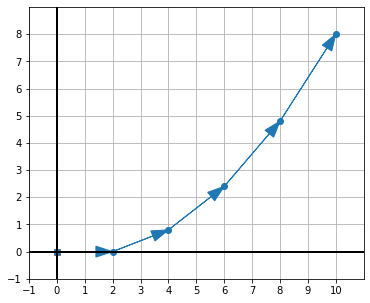

In [21]:
from my_draw2d import draw2d, Points2D, Arrow2D
from my_colors import blue

positions=[(0, 0), (2, 0), (4, 0.8), (6, 2.4000000000000004), (8, 4.800000000000001), (10, 8.0)]

arrows = [Arrow2D(positions[i + 1], positions[i], color=blue) for i in range(0, len(positions) - 1)]

draw2d(
    Points2D(*positions, color=blue),
    *arrows
)

## Running Euler's method with smaller time steps

Now that we have the algorithm implemented in Python, we can rerun the scenario with smaller time intervals and see what happens.

The expectations is that the plot will become less jagged.

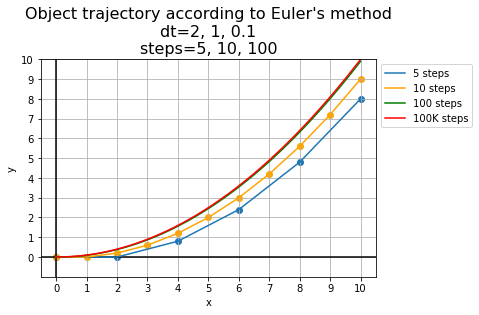

In [1]:
from my_vectors import add, scale
import matplotlib.pyplot as plt


def get_euler_method_fn(t0, s0, v0, a0):
    def new_function(dt, steps):
        s = s0
        t = t0
        v = v0
        a = a0
        positions = [s0]
        for _ in range(0, steps):
            t += dt
            s = add(s, scale(dt, v))
            v = add(v, scale(dt, a))
            positions.append(s)
        return positions
    return new_function

simulation = get_euler_method_fn(t0=0, s0=(0,0), v0=(1,0), a0=(0, 0.2))

positions_5_steps = simulation(dt=2, steps=5)
positions_10_steps = simulation(dt=1, steps=10)
positions_100_steps = simulation(dt=0.1, steps=100)
positions_100K_steps = simulation(dt=0.0001, steps=100000)


fig, ax = plt.subplots()
ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.title(
    'Object trajectory according to Euler\'s method\n'
    'dt=2, 1, 0.1\n'
    'steps=5, 10, 100', fontsize=16)

plt.ylim(-1, 10)
plt.xticks(range(0, 11))
plt.yticks(range(0, 11))

# plotting trajectories as a scatter plots
xs = [x for (x, _) in positions_5_steps]
ys = [y for (_, y) in positions_5_steps]
plt.scatter(xs, ys, color='C0')
plt.plot(xs, ys, label='5 steps', color='C0')

xs = [x for (x, _) in positions_10_steps]
ys = [y for (_, y) in positions_10_steps]
plt.scatter(xs, ys, color='orange')
plt.plot(xs, ys, label='10 steps', color='orange')

xs = [x for (x, _) in positions_100_steps]
ys = [y for (_, y) in positions_100_steps]
plt.plot(xs, ys, label='100 steps', color='green')

xs = [x for (x, _) in positions_100K_steps]
ys = [y for (_, y) in positions_100K_steps]
plt.plot(xs, ys, label='100K steps', color='red')

plt.xlabel(r'x')
plt.ylabel(r'y')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

Note that it is not yet what we expected &mdash; it is not that when decreasing the interval and therefore the number of steps the curve gets smoother, but actually, the trajectory will be slightly different when doing so.

This is because the formula:

$
\displaystyle
\Delta s = v \cdot \Delta t
$

is only correct when the velocity is constant. Thus, the Euler's method will be more and more accurate when the interval gets smaller and smaller, as velocity won't change much in those small intervals.

Note also, that when we plot the simulation with 100K steps it is almost indistiguishable from the 100 steps.

## You know you've mastered this chapter when...

+ You're familiar with the formulas for velocity and acceleration

$$
\displaystyle
v = \frac{\Delta s}{\Delta t} \\
a = \frac{\Delta v}{\Delta t} \\
$$

+ You know how to define the *Velocity* as the derivative of position with respect to time.
    + You are aware that the *velocity* is a vector consisting of the derivatives of each of the position functions (e.g. $ v(t) = (x'(t), \, y'(t)) $ where $ s(t) = (x, \, y) $ is the position vector.

+ You're aware of how to animate objects moving at a constant velocity by updating its position in each frame. 
    + Measuring the time between frames and multiplying it by the object's velocity gives you the change in position for the frame.

+ You know how to define the *Acceleration* as the derivative of velocity with respect to time.
    + You are aware that the *acceleration* is a vector consisting of the derivatives of each of the velocity functions (e.g. $ a(t) = (v_x'(t), \, v_y'(t)) $ where $ v(t) = (v_x, \, v_y) $ is the velocity vector.

+ You're aware that to simulate an accelerating object, you need to update its position and keep track of its velocity in each frame.

+ You're familiar with the *Euler's method*:
    + if you know the rate at which a quantity changes with respect to time, you can compute the value of a quantity itself over time by calculating the quantity's change over many small time intervals.

+ You know how to use the Euler's method by hand and programmatically.

+ You're comfortable finding the position of objects over time using the *Euler's method*.

+ You understand that the smaller steps used when computing the *Euler's method*, the most accurate the trajectory of the object will be, because $ s = v \cdot t $ only if $ v $ is constant.